In [23]:
import sys
sys.path.append('..')
import torch
import numpy as np
import matplotlib.pyplot as plt
from sympy import simplify_logic

from deep_logic import validate_network, prune_equal_fanin, collect_parameters, get_reduced_model
from deep_logic import fol

torch.manual_seed(0)
np.random.seed(0)

In [24]:
# XOR problem
x_train = torch.tensor([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1],
], dtype=torch.float)
y_train = torch.tensor([0, 1, 1, 0], dtype=torch.float).unsqueeze(1)


x_test = torch.tensor([
    [0, 0.95],
    [0, 0.9],
    [0.05, 1],
    [0.1, 0.8],
    [0.45, 1],
    [0, 0.35],
    [0.75, 0.2],
    [0.75, 0.15],
], dtype=torch.float)
y_test = torch.tensor([1, 1, 1, 1, 1, 0, 1, 1], dtype=torch.float).unsqueeze(1)

In [25]:
layers = [
    torch.nn.Linear(x_train.size(1), 10, bias=False),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 4, bias=False),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 1, bias=False),
    torch.nn.Sigmoid(),
]
model = torch.nn.Sequential(*layers)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
need_pruning = True
for epoch in range(1000):
    # forward pass
    optimizer.zero_grad()
    y_pred = model(x_train)
    # Compute Loss
    loss = torch.nn.functional.mse_loss(y_pred, y_train)

    for module in model.children():
        if isinstance(module, torch.nn.Linear):
            loss += 0.0001 * torch.norm(module.weight, 1)

    # backward pass
    loss.backward()
    optimizer.step()

    # compute accuracy
    if epoch % 100 == 0:
        y_pred_d = (y_pred > 0.5)
        accuracy = (y_pred_d.eq(y_train).sum(dim=1) == y_train.size(1)).sum().item() / y_train.size(0)
        print(f'Epoch {epoch}: train accuracy: {accuracy:.4f}')

Epoch 0: train accuracy: 0.7500
Epoch 100: train accuracy: 1.0000
Epoch 200: train accuracy: 1.0000
Epoch 300: train accuracy: 1.0000
Epoch 400: train accuracy: 1.0000
Epoch 500: train accuracy: 1.0000
Epoch 600: train accuracy: 1.0000
Epoch 700: train accuracy: 1.0000
Epoch 800: train accuracy: 1.0000
Epoch 900: train accuracy: 1.0000


# Decision boundaries

In [26]:
def plot_decision_bundaries(model, x, h=0.1, cmap='BrBG', torch_model=True):
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                           np.arange(x2_min, x2_max, h))
    if torch_model:
        xx = torch.FloatTensor(np.c_[xx1.ravel(), xx2.ravel()])
        Z = model(xx).detach().numpy()
    else:
        xx = np.c_[xx1.ravel(), xx2.ravel()]
        Z = model.predict_proba(xx)[:, 1]
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
    return

## True decision boundaries

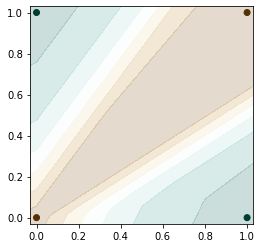

In [27]:
xnp = x_train.detach().numpy()
ynp = y_train.detach().numpy().ravel()
cmap='BrBG'

plt.figure(figsize=[4, 4])
plot_decision_bundaries(model, x_train, h=0.01, cmap=cmap)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.03, 1.03])
plt.ylim([-0.03, 1.03])
plt.show()

## Local decision boundaries

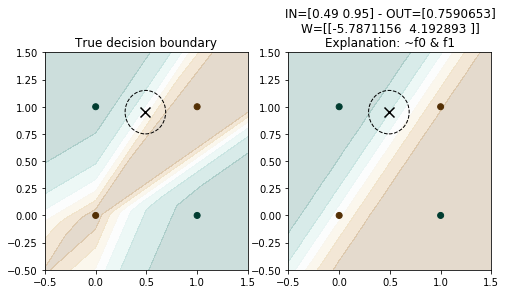

In [28]:
xin = torch.tensor([0.49, 0.95])
model_reduced = get_reduced_model(model, xin)
for module in model_reduced.children():
    if isinstance(module, torch.nn.Linear):
        wa = module.weight.detach().numpy()
        break
output = model_reduced(xin)
explanation = fol.generate_local_explanations(model_reduced, xin)

plt.figure(figsize=[8, 4])
plt.subplot(121)
plt.title('True decision boundary')
plot_decision_bundaries(model, x_train, h=0.01, cmap=cmap)
plt.scatter(xin[0], xin[1], c='k', marker='x', s=100)
c = plt.Circle((xin[0], xin[1]), radius=0.2, edgecolor='k', fill=False, linestyle='--')
plt.gca().add_artist(c)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.subplot(122)
plt.title(f'IN={xin.detach().numpy()} - OUT={output.detach().numpy()}\nW={wa}\nExplanation: {explanation}')
plot_decision_bundaries(model_reduced, x_train)
plt.scatter(xin[0], xin[1], c='k', marker='x', s=100)
c = plt.Circle((xin[0], xin[1]), radius=0.2, edgecolor='k', fill=False, linestyle='--')
plt.gca().add_artist(c)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.show()

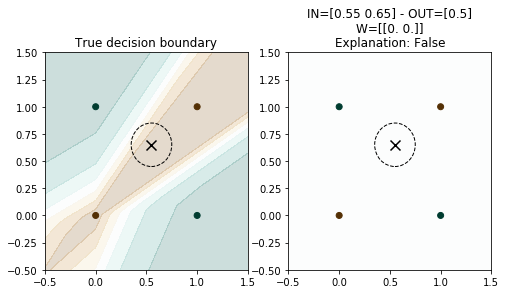

In [29]:
xin = torch.tensor([0.55, 0.65])
model_reduced = get_reduced_model(model, xin)
for module in model_reduced.children():
    if isinstance(module, torch.nn.Linear):
        wa = module.weight.detach().numpy()
        break
output = model_reduced(xin)
explanation = fol.generate_local_explanations(model_reduced, xin)

plt.figure(figsize=[8, 4])
plt.subplot(121)
plt.title('True decision boundary')
plot_decision_bundaries(model, x_train, h=0.01, cmap=cmap)
plt.scatter(xin[0], xin[1], c='k', marker='x', s=100)
c = plt.Circle((xin[0], xin[1]), radius=0.2, edgecolor='k', fill=False, linestyle='--')
plt.gca().add_artist(c)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.subplot(122)
plt.title(f'IN={xin.detach().numpy()} - OUT={output.detach().numpy()}\nW={wa}\nExplanation: {explanation}')
plot_decision_bundaries(model_reduced, x_train)
plt.scatter(xin[0], xin[1], c='k', marker='x', s=100)
c = plt.Circle((xin[0], xin[1]), radius=0.2, edgecolor='k', fill=False, linestyle='--')
plt.gca().add_artist(c)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.show()

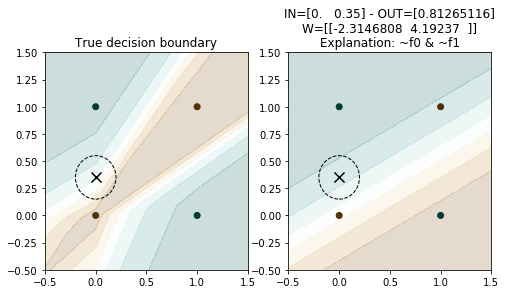

In [30]:
xin = torch.tensor([0, 0.35])
model_reduced = get_reduced_model(model, xin)
for module in model_reduced.children():
    if isinstance(module, torch.nn.Linear):
        wa = module.weight.detach().numpy()
        break
output = model_reduced(xin)
explanation = fol.generate_local_explanations(model_reduced, xin)

plt.figure(figsize=[8, 4])
plt.subplot(121)
plt.title('True decision boundary')
plot_decision_bundaries(model, x_train, h=0.01, cmap=cmap)
plt.scatter(xin[0], xin[1], c='k', marker='x', s=100)
c = plt.Circle((xin[0], xin[1]), radius=0.2, edgecolor='k', fill=False, linestyle='--')
plt.gca().add_artist(c)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.subplot(122)
plt.title(f'IN={xin.detach().numpy()} - OUT={output.detach().numpy()}\nW={wa}\nExplanation: {explanation}')
plot_decision_bundaries(model_reduced, x_train)
plt.scatter(xin[0], xin[1], c='k', marker='x', s=100)
c = plt.Circle((xin[0], xin[1]), radius=0.2, edgecolor='k', fill=False, linestyle='--')
plt.gca().add_artist(c)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.show()

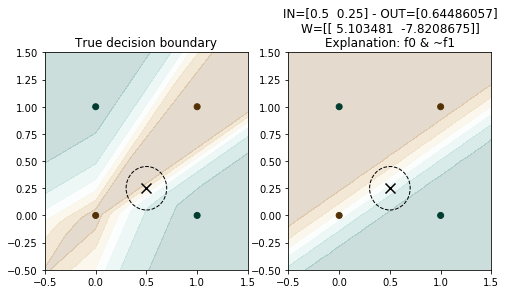

In [31]:
xin = torch.tensor([0.5, 0.25])
model_reduced = get_reduced_model(model, xin)
for module in model_reduced.children():
    if isinstance(module, torch.nn.Linear):
        wa = module.weight.detach().numpy()
        break
output = model_reduced(xin)
explanation = fol.generate_local_explanations(model_reduced, xin)

plt.figure(figsize=[8, 4])
plt.subplot(121)
plt.title('True decision boundary')
plot_decision_bundaries(model, x_train, h=0.01, cmap=cmap)
plt.scatter(xin[0], xin[1], c='k', marker='x', s=100)
c = plt.Circle((xin[0], xin[1]), radius=0.2, edgecolor='k', fill=False, linestyle='--')
plt.gca().add_artist(c)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.subplot(122)
plt.title(f'IN={xin.detach().numpy()} - OUT={output.detach().numpy()}\nW={wa}\nExplanation: {explanation}')
plot_decision_bundaries(model_reduced, x_train)
plt.scatter(xin[0], xin[1], c='k', marker='x', s=100)
c = plt.Circle((xin[0], xin[1]), radius=0.2, edgecolor='k', fill=False, linestyle='--')
plt.gca().add_artist(c)
plt.scatter(xnp[:, 0], xnp[:, 1], c=ynp, cmap=cmap)
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.show()

# Combine local explanations

In [32]:
global_explanation = ''
for xin, yin in zip(x_test, y_test):
    model_reduced = get_reduced_model(model, xin)
    output = model_reduced(xin)
    if output > 0.5 and (output>0.5) == yin:
        local_explanation = fol.generate_local_explanations(model_reduced, xin)
        global_explanation += f'{local_explanation} | '
global_explanation = global_explanation[:-3]
global_explanation

'~f0 & f1 | ~f0 & f1 | ~f0 & f1 | ~f0 & f1 | ~f0 & f1 | f0 & ~f1 | f0 & ~f1'

In [33]:
simplified_explanation = simplify_logic(global_explanation, 'dnf')
simplified_explanation

(f0 & ~f1) | (f1 & ~f0)